#### Load library

In [23]:
import os
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision import models


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

### Load Dataset

In [25]:
from torchvision import transforms
from torchvision.transforms import functional as TF

# class PadToSquare:
#     def __call__(self, img):
#         w, h = img.size
#         max_wh = max(w, h)
#         pad_left = (max_wh - w) // 2
#         pad_top = (max_wh - h) // 2
#         pad_right = max_wh - w - pad_left
#         pad_bottom = max_wh - h - pad_top
#         return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=0)

# # 최종 transform
# transform = transforms.Compose([
#     PadToSquare(),                   # 먼저 정사각형 패딩
#     transforms.Resize((120, 120)),    # 원하는 크기로 resize
#     transforms.ToTensor()
# ])
# 실제 적용할 transform

normalize = transforms.Normalize(mean=[0.5184, 0.4233, 0.3783],
                                 std=[0.2486, 0.2229, 0.2204])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])


In [26]:
# 정규화 및 transform 설정


# 경로
train_dir = '/Users/kim-yujin/Desktop/Ajou univ_교과/2025/2025-1/기계학습/팀프로젝트/cropped_dataset/eyes_nose/train'
test_dir = '/Users/kim-yujin/Desktop/Ajou univ_교과/2025/2025-1/기계학습/팀프로젝트/mod_dataset/test'

# 전체 데이터셋 불러오기
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 클래스 라벨 매핑
class_to_idx = full_train_dataset.class_to_idx
print("클래스 라벨 매핑:", class_to_idx)  # 예: {'fake': 0, 'real': 1}

# 각 클래스별 valid 인덱스 500개씩 추출
targets = np.array(full_train_dataset.targets)
valid_idx = []

for class_id in np.unique(targets):
    class_indices = np.where(targets == class_id)[0]
    selected = np.random.choice(class_indices, 500, replace=False)
    valid_idx.extend(selected)

# train 인덱스 = 전체 - valid
valid_idx = set(valid_idx)
all_idx = set(range(len(full_train_dataset)))
train_idx = list(all_idx - valid_idx)
valid_idx = list(valid_idx)

# Subset으로 나누기
train_dataset = Subset(full_train_dataset, train_idx)
valid_dataset = Subset(full_train_dataset, valid_idx)

# DataLoader 설정
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 각 로더 길이 출력
print(f"Train Loader Length: {len(train_loader)} batches ({len(train_dataset)} samples)")
print(f"Valid Loader Length: {len(valid_loader)} batches ({len(valid_dataset)} samples)")
print(f"Test Loader Length:  {len(test_loader)} batches ({len(test_dataset)} samples)")
print("클래스 이름 목록:", test_dataset.classes)


클래스 라벨 매핑: {'fake': 0, 'real': 1}
Train Loader Length: 63 batches (3999 samples)
Valid Loader Length: 16 batches (1000 samples)
Test Loader Length:  2 batches (100 samples)
클래스 이름 목록: ['real']


In [29]:
from torch.utils.data import Dataset

class FixedLabelDataset(Dataset):
    def __init__(self, base_dataset, fixed_label):
        self.base = base_dataset
        self.fixed_label = fixed_label  # 예: 1 = real

    def __getitem__(self, index):
        x, _ = self.base[index]  # 기존 라벨 무시
        return x, self.fixed_label

    def __len__(self):
        return len(self.base)

# 적용하기
# 원래 ImageFolder로 만든 test_dataset을 감싸서 "모든 라벨을 1 (real)"로 만듦
test_dataset = FixedLabelDataset(test_dataset, fixed_label=1)

# 다시 DataLoader 생성
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


#### train & test

In [7]:
# Traninig
device = "mps"

def train(model, dataloader, device, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)                        # (batch, 1)
        loss = criterion(outputs, labels)              # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5           # threshold
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)

    return correct / total, total_loss / len(dataloader)

def test(model, dataloader, device, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

    return correct / total, total_loss / len(dataloader)

#### evaluate

In [8]:
def plot_loss_accuracy(logs):
    import matplotlib.pyplot as plt

    epochs = range(1, len(logs['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, logs['train_loss'], label='Train Loss')
    plt.plot(epochs, logs['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, logs['train_acc'], label='Train Acc')
    plt.plot(epochs, logs['val_acc'], label='Validation Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
def compute_metrics(model, dataloader, device):
    import torch
    from sklearn.metrics import confusion_matrix, classification_report

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())

    report = classification_report(all_labels, all_preds, target_names=['fake', 'real'], output_dict=True)
    acc = report['accuracy']
    recall = report['real']['recall']
    f1 = report['real']['f1-score']
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp)

    print(f"Accuracy: {acc:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")


In [10]:
def plot_confusion_matrix(model, dataloader, device):
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [11]:
def plot_roc_curve(model, dataloader, device):
    import torch
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.numpy())

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc='lower right')
    plt.show()


In [12]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total}")
    print(f"Trainable Parameters: {trainable}")


In [13]:
def measure_inference_time_per_image(model, dataloader, device, max_images=100):
    import time
    model.eval()
    total_images = 0
    total_time = 0.0

    with torch.no_grad():
        for images, _ in dataloader:
            batch_size = images.size(0)
            images = images.to(device)

            start_time = time.time()
            _ = model(images)
            elapsed = time.time() - start_time

            total_images += batch_size
            total_time += elapsed

            if total_images >= max_images:
                break

    avg_time_per_image = total_time / total_images
    print(f"Average inference time per image (on {total_images} images): {avg_time_per_image:.6f} seconds")


#### FC만 학습

In [ ]:
# model
def get_resnet50_fc_only():
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

In [ ]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_resnet50_fc_only().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/resnet50_fc_only_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        # test_acc, test_loss = test(model, test_loader, device, criterion)
        # print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.6865, train_acc = 0.6432 | val_loss = 0.5655, val_acc = 0.6930


  1%|          | 1/100 [00:09<15:10,  9.20s/it]

[Epoch 1] train_loss = 0.5554, train_acc = 0.7157 | val_loss = 0.6035, val_acc = 0.6800


  2%|▏         | 2/100 [00:18<14:59,  9.18s/it]

[Epoch 2] train_loss = 0.5327, train_acc = 0.7312 | val_loss = 0.5112, val_acc = 0.7370


  3%|▎         | 3/100 [00:27<14:52,  9.20s/it]

[Epoch 3] train_loss = 0.5188, train_acc = 0.7430 | val_loss = 0.6484, val_acc = 0.6690


  4%|▍         | 4/100 [00:36<14:39,  9.16s/it]

[Epoch 4] train_loss = 0.4648, train_acc = 0.7833 | val_loss = 0.4840, val_acc = 0.7660


  5%|▌         | 5/100 [00:45<14:24,  9.10s/it]

[Epoch 5] train_loss = 0.4820, train_acc = 0.7658 | val_loss = 0.5195, val_acc = 0.7440


  6%|▌         | 6/100 [00:54<14:16,  9.11s/it]

[Epoch 6] train_loss = 0.4682, train_acc = 0.7765 | val_loss = 0.4793, val_acc = 0.7690


  7%|▋         | 7/100 [01:03<14:07,  9.11s/it]

[Epoch 7] train_loss = 0.4795, train_acc = 0.7700 | val_loss = 0.5225, val_acc = 0.7370


  8%|▊         | 8/100 [01:13<14:00,  9.14s/it]

[Epoch 8] train_loss = 0.4277, train_acc = 0.7945 | val_loss = 0.5024, val_acc = 0.7590


  9%|▉         | 9/100 [01:22<13:53,  9.16s/it]

[Epoch 9] train_loss = 0.4279, train_acc = 0.8043 | val_loss = 0.4698, val_acc = 0.7750


 10%|█         | 10/100 [01:31<13:40,  9.11s/it]

[Epoch 10] train_loss = 0.4242, train_acc = 0.8000 | val_loss = 0.4725, val_acc = 0.7690


 11%|█         | 11/100 [01:40<13:30,  9.11s/it]

[Epoch 11] train_loss = 0.4257, train_acc = 0.7960 | val_loss = 0.4808, val_acc = 0.7730


 12%|█▏        | 12/100 [01:49<13:17,  9.06s/it]

[Epoch 12] train_loss = 0.4084, train_acc = 0.8095 | val_loss = 0.5627, val_acc = 0.7140


 13%|█▎        | 13/100 [01:58<13:05,  9.03s/it]

[Epoch 13] train_loss = 0.4715, train_acc = 0.7780 | val_loss = 0.5106, val_acc = 0.7470


 14%|█▍        | 14/100 [02:07<12:50,  8.96s/it]

[Epoch 14] train_loss = 0.4276, train_acc = 0.7980 | val_loss = 0.4681, val_acc = 0.7780


 15%|█▌        | 15/100 [02:16<12:48,  9.04s/it]

[Epoch 15] train_loss = 0.4138, train_acc = 0.8003 | val_loss = 0.4849, val_acc = 0.7630


 16%|█▌        | 16/100 [02:25<12:39,  9.04s/it]

[Epoch 16] train_loss = 0.4156, train_acc = 0.8057 | val_loss = 0.4663, val_acc = 0.7720


 17%|█▋        | 17/100 [02:34<12:35,  9.10s/it]

[Epoch 17] train_loss = 0.4033, train_acc = 0.8157 | val_loss = 0.4628, val_acc = 0.7790


 18%|█▊        | 18/100 [02:44<12:32,  9.18s/it]

[Epoch 18] train_loss = 0.3914, train_acc = 0.8210 | val_loss = 0.4636, val_acc = 0.7740


 19%|█▉        | 19/100 [02:53<12:24,  9.19s/it]

[Epoch 19] train_loss = 0.4136, train_acc = 0.8080 | val_loss = 0.5384, val_acc = 0.7420


 20%|██        | 20/100 [03:02<12:13,  9.17s/it]

[Epoch 20] train_loss = 0.3876, train_acc = 0.8207 | val_loss = 0.4577, val_acc = 0.7880


 21%|██        | 21/100 [03:11<12:06,  9.20s/it]

[Epoch 21] train_loss = 0.4178, train_acc = 0.8075 | val_loss = 0.4571, val_acc = 0.7880


 22%|██▏       | 22/100 [03:20<11:58,  9.21s/it]

[Epoch 22] train_loss = 0.4130, train_acc = 0.8050 | val_loss = 0.5183, val_acc = 0.7550


 23%|██▎       | 23/100 [03:30<11:49,  9.21s/it]

[Epoch 23] train_loss = 0.4312, train_acc = 0.7975 | val_loss = 0.5171, val_acc = 0.7470


 24%|██▍       | 24/100 [03:38<11:31,  9.10s/it]

[Epoch 24] train_loss = 0.3764, train_acc = 0.8303 | val_loss = 0.4926, val_acc = 0.7540


 25%|██▌       | 25/100 [03:47<11:16,  9.02s/it]

[Epoch 25] train_loss = 0.3766, train_acc = 0.8270 | val_loss = 0.4555, val_acc = 0.7880


 26%|██▌       | 26/100 [03:56<11:09,  9.04s/it]

[Epoch 26] train_loss = 0.3941, train_acc = 0.8165 | val_loss = 0.5054, val_acc = 0.7510


 27%|██▋       | 27/100 [04:05<11:00,  9.05s/it]

[Epoch 27] train_loss = 0.3659, train_acc = 0.8360 | val_loss = 0.4890, val_acc = 0.7690


 28%|██▊       | 28/100 [04:14<10:50,  9.03s/it]

[Epoch 28] train_loss = 0.3663, train_acc = 0.8323 | val_loss = 0.4754, val_acc = 0.7700


 29%|██▉       | 29/100 [04:24<10:42,  9.05s/it]

[Epoch 29] train_loss = 0.3730, train_acc = 0.8313 | val_loss = 0.4520, val_acc = 0.7860


 30%|███       | 30/100 [04:32<10:30,  9.01s/it]

[Epoch 30] train_loss = 0.3475, train_acc = 0.8528 | val_loss = 0.4620, val_acc = 0.7750


 31%|███       | 31/100 [04:42<10:23,  9.04s/it]

[Epoch 31] train_loss = 0.3519, train_acc = 0.8403 | val_loss = 0.4780, val_acc = 0.7640


 32%|███▏      | 32/100 [04:50<10:09,  8.97s/it]

[Epoch 32] train_loss = 0.4019, train_acc = 0.8163 | val_loss = 0.5415, val_acc = 0.7530


 33%|███▎      | 33/100 [04:59<10:02,  8.99s/it]

[Epoch 33] train_loss = 0.3898, train_acc = 0.8235 | val_loss = 0.5210, val_acc = 0.7590


 34%|███▍      | 34/100 [05:08<09:48,  8.92s/it]

[Epoch 34] train_loss = 0.3949, train_acc = 0.8207 | val_loss = 0.4473, val_acc = 0.8020


 35%|███▌      | 35/100 [05:17<09:40,  8.93s/it]

[Epoch 35] train_loss = 0.3411, train_acc = 0.8478 | val_loss = 0.5883, val_acc = 0.7290


 36%|███▌      | 36/100 [05:26<09:34,  8.98s/it]

[Epoch 36] train_loss = 0.3456, train_acc = 0.8427 | val_loss = 0.4544, val_acc = 0.7980


 37%|███▋      | 37/100 [05:35<09:25,  8.98s/it]

[Epoch 37] train_loss = 0.3624, train_acc = 0.8438 | val_loss = 0.4735, val_acc = 0.7660


 38%|███▊      | 38/100 [05:44<09:18,  9.00s/it]

[Epoch 38] train_loss = 0.3351, train_acc = 0.8525 | val_loss = 0.4469, val_acc = 0.7950


 39%|███▉      | 39/100 [05:53<09:11,  9.05s/it]

[Epoch 39] train_loss = 0.3407, train_acc = 0.8515 | val_loss = 0.4451, val_acc = 0.7970


 40%|████      | 40/100 [06:03<09:09,  9.16s/it]

[Epoch 40] train_loss = 0.3407, train_acc = 0.8492 | val_loss = 0.4984, val_acc = 0.7700


 41%|████      | 41/100 [06:12<08:57,  9.12s/it]

[Epoch 41] train_loss = 0.3600, train_acc = 0.8360 | val_loss = 0.4481, val_acc = 0.7970


 42%|████▏     | 42/100 [06:21<08:42,  9.01s/it]

[Epoch 42] train_loss = 0.3565, train_acc = 0.8490 | val_loss = 0.4883, val_acc = 0.7670


 43%|████▎     | 43/100 [06:30<08:34,  9.03s/it]

[Epoch 43] train_loss = 0.3503, train_acc = 0.8445 | val_loss = 0.4432, val_acc = 0.7990


 44%|████▍     | 44/100 [06:39<08:26,  9.05s/it]

[Epoch 44] train_loss = 0.3230, train_acc = 0.8622 | val_loss = 0.5046, val_acc = 0.7520


 45%|████▌     | 45/100 [06:48<08:17,  9.05s/it]

[Epoch 45] train_loss = 0.3592, train_acc = 0.8390 | val_loss = 0.4387, val_acc = 0.7990


 46%|████▌     | 46/100 [06:57<08:07,  9.04s/it]

[Epoch 46] train_loss = 0.3273, train_acc = 0.8558 | val_loss = 0.4521, val_acc = 0.7920


 47%|████▋     | 47/100 [07:06<08:01,  9.08s/it]

[Epoch 47] train_loss = 0.3508, train_acc = 0.8403 | val_loss = 0.4498, val_acc = 0.7880


 48%|████▊     | 48/100 [07:15<07:52,  9.08s/it]

[Epoch 48] train_loss = 0.3298, train_acc = 0.8550 | val_loss = 0.4651, val_acc = 0.7840


 49%|████▉     | 49/100 [07:24<07:39,  9.01s/it]

[Epoch 49] train_loss = 0.3209, train_acc = 0.8608 | val_loss = 0.4639, val_acc = 0.7820


 50%|█████     | 50/100 [07:33<07:28,  8.97s/it]

[Epoch 50] train_loss = 0.3133, train_acc = 0.8695 | val_loss = 0.4423, val_acc = 0.7990


 50%|█████     | 50/100 [07:42<07:42,  9.25s/it]

Early stopping triggered


Final Test Accuracy: 0.8050


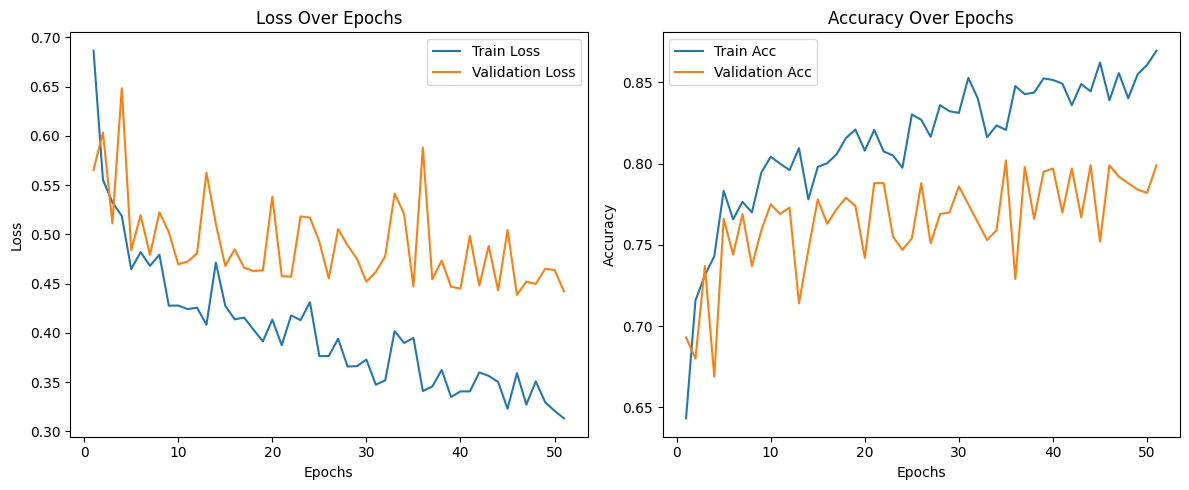

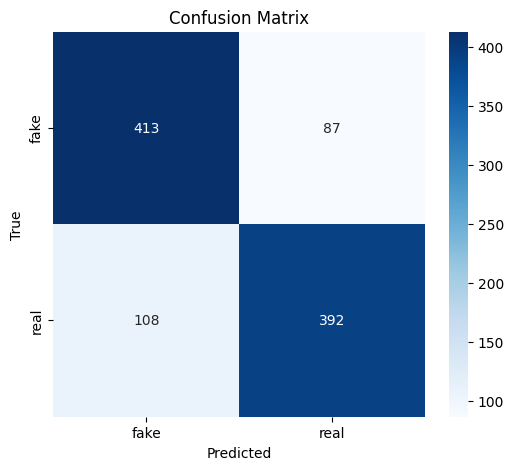

Accuracy: 0.8050
Recall (Sensitivity): 0.7840
F1-score: 0.8008
Specificity: 0.8260


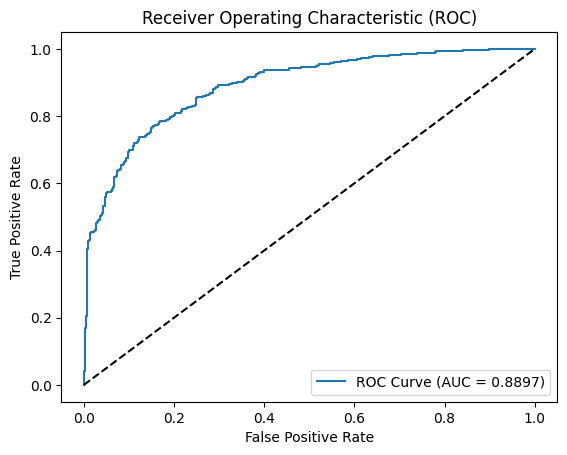

Total Parameters: 23510081
Trainable Parameters: 2049
Average inference time per image (on 128 images): 0.000201 seconds


In [ ]:
# 모델 정의
model = get_resnet50_fc_only().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/resnet50_fc_only_best.pth", map_location=device))

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### FC + BN

In [ ]:
def get_resnet50_fc_bn():
    model = models.resnet50(pretrained=True)
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            for param in module.parameters():
                param.requires_grad = True
        else:
            for param in module.parameters():
                param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)
    for param in model.fc.parameters():
        param.requires_grad = True
    return model


In [ ]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_resnet50_fc_bn().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        # torch.save(model.state_dict(), "checkpoints/resnet50_fc_bc_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        test_acc, test_loss = test(model, test_loader, device, criterion)
        print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.5738, train_acc = 0.7053 | val_loss = 0.5342, val_acc = 0.7340


  1%|          | 1/100 [00:09<15:27,  9.37s/it]

[Epoch 1] train_loss = 0.3689, train_acc = 0.8397 | val_loss = 0.3778, val_acc = 0.8370


  2%|▏         | 2/100 [00:18<15:00,  9.19s/it]

[Epoch 2] train_loss = 0.2069, train_acc = 0.9275 | val_loss = 0.3217, val_acc = 0.8740


  3%|▎         | 3/100 [00:27<14:33,  9.00s/it]

[Epoch 3] train_loss = 0.1127, train_acc = 0.9605 | val_loss = 0.2645, val_acc = 0.8890


  4%|▍         | 4/100 [00:36<14:20,  8.97s/it]

[Epoch 4] train_loss = 0.0617, train_acc = 0.9835 | val_loss = 0.3097, val_acc = 0.8950


  5%|▌         | 5/100 [00:45<14:11,  8.97s/it]

[Epoch 5] train_loss = 0.0295, train_acc = 0.9942 | val_loss = 0.2764, val_acc = 0.8980


  6%|▌         | 6/100 [00:53<14:00,  8.94s/it]

[Epoch 6] train_loss = 0.0164, train_acc = 0.9982 | val_loss = 0.2857, val_acc = 0.9040


  7%|▋         | 7/100 [01:02<13:45,  8.88s/it]

[Epoch 7] train_loss = 0.0106, train_acc = 0.9990 | val_loss = 0.3583, val_acc = 0.8830


  8%|▊         | 8/100 [01:11<13:41,  8.92s/it]

[Epoch 8] train_loss = 0.0087, train_acc = 0.9995 | val_loss = 0.2898, val_acc = 0.9110
Early stopping triggered


  8%|▊         | 8/100 [01:22<15:45, 10.28s/it]

Final Test Accuracy: 0.8980


Final Test Accuracy: 0.8980


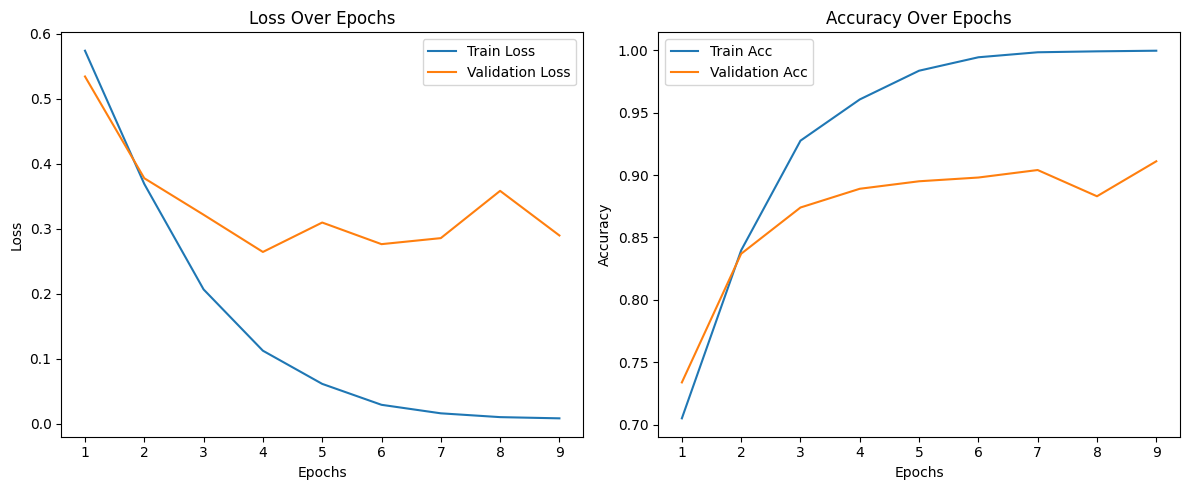

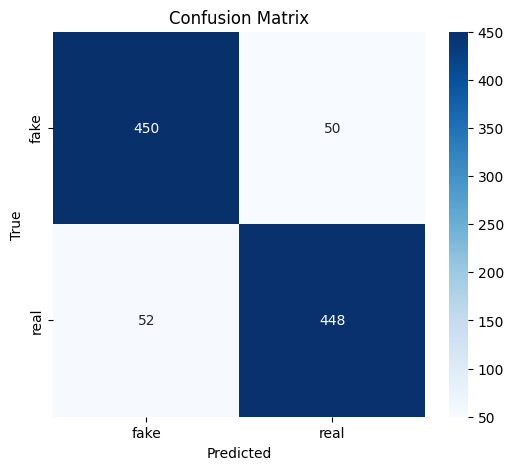

Accuracy: 0.8980
Recall (Sensitivity): 0.8960
F1-score: 0.8978
Specificity: 0.9000


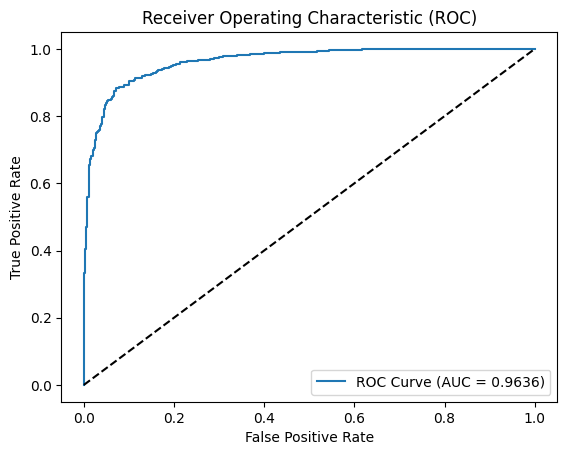

Total Parameters: 23510081
Trainable Parameters: 55169
Average inference time per image (on 128 images): 0.000186 seconds


In [ ]:
# 모델 정의
model = get_resnet50_fc_bn().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/resnet50_fc_bc_best.pth", map_location=device))
test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")
# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 학습 X - 출력층 노드 개수만 변환

In [ ]:
def get_resnet50_zeroshot():
    model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False  # 전체 freeze

    model.fc = nn.Linear(model.fc.in_features, 1)  # 출력 바꾸기
    for param in model.fc.parameters():
        param.requires_grad = False  # fc까지 freeze

    return model


In [ ]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

best_loss = np.inf

model = get_resnet50_zeroshot().to(device)


test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.4960


Final Test Accuracy: 0.4960


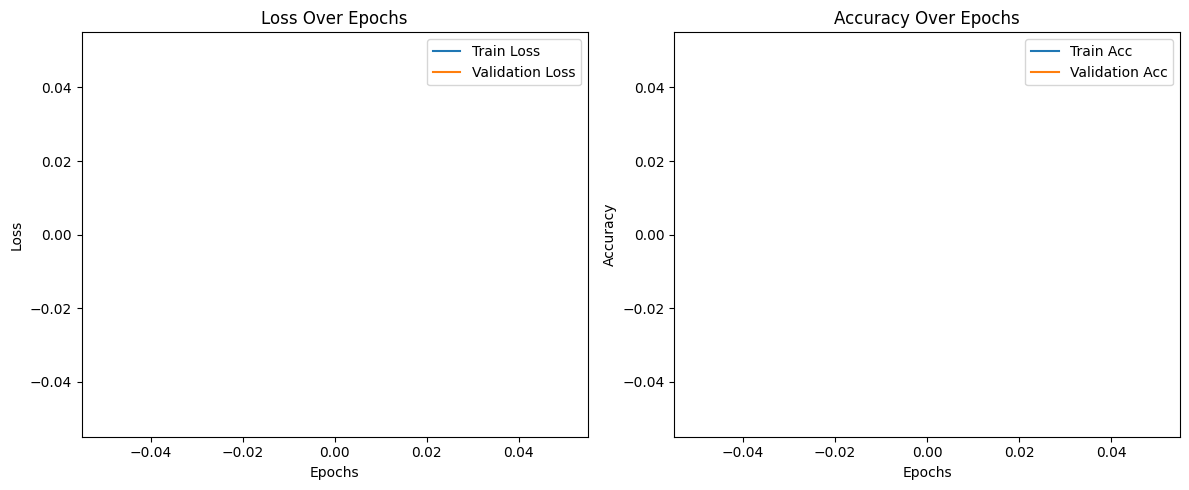

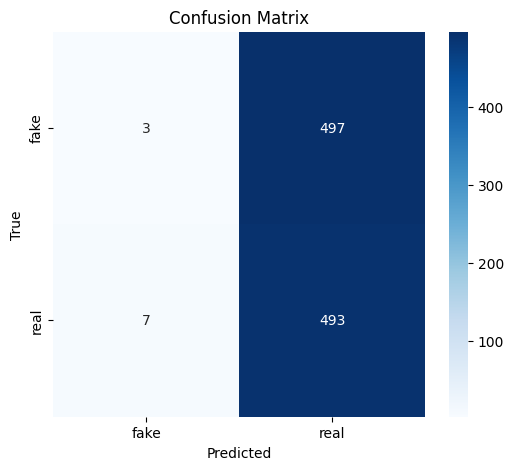

Accuracy: 0.4960
Recall (Sensitivity): 0.9860
F1-score: 0.6617
Specificity: 0.0060


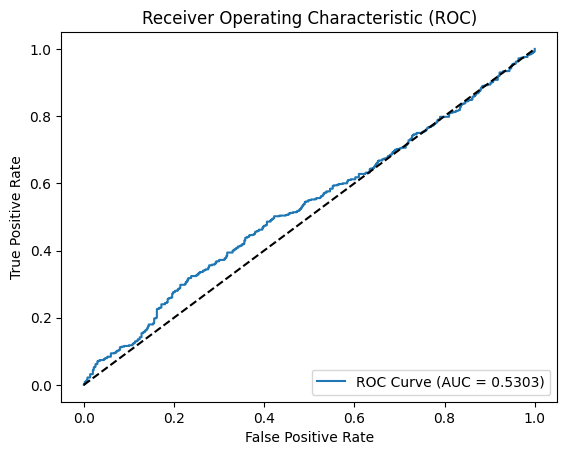

Total Parameters: 23510081
Trainable Parameters: 0
Average inference time per image (on 128 images): 0.000217 seconds


In [ ]:
# # 모델 정의
# model = get_resnet50_zeroshot().to(device)

# # 저장된 파라미터 로드
# model.load_state_dict(torch.load("checkpoints/resnet50_fc_node_best.pth", map_location=device))
test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")
# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 상위 블록만 학습

In [ ]:
def get_resnet50_partial_tune(n_blocks=3):
    model = models.resnet50(pretrained=True)
    # 전체 freeze
    for param in model.parameters():
        param.requires_grad = False

    # 마지막 n_blocks만 학습 가능하도록 설정
    blocks = [model.layer1, model.layer2, model.layer3, model.layer4]
    for block in blocks[-n_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, 1)
    for param in model.fc.parameters():
        param.requires_grad = True
    return model


In [ ]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_resnet50_partial_tune().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        # torch.save(model.state_dict(), "checkpoints/resnet50_partial_4_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        test_acc, test_loss = test(model, test_loader, device, criterion)
        print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.4285, train_acc = 0.8005 | val_loss = 0.5352, val_acc = 0.8400


  1%|          | 1/100 [00:08<14:46,  8.96s/it]

[Epoch 1] train_loss = 0.1645, train_acc = 0.9330 | val_loss = 0.4371, val_acc = 0.8410


  2%|▏         | 2/100 [00:17<14:37,  8.95s/it]

[Epoch 2] train_loss = 0.1010, train_acc = 0.9633 | val_loss = 0.4007, val_acc = 0.8760


  3%|▎         | 3/100 [00:26<14:19,  8.86s/it]

[Epoch 3] train_loss = 0.0795, train_acc = 0.9685 | val_loss = 0.3963, val_acc = 0.8580


  4%|▍         | 4/100 [00:35<14:04,  8.80s/it]

[Epoch 4] train_loss = 0.0352, train_acc = 0.9870 | val_loss = 0.3859, val_acc = 0.8910


  5%|▌         | 5/100 [00:44<14:03,  8.88s/it]

[Epoch 5] train_loss = 0.0345, train_acc = 0.9875 | val_loss = 0.5555, val_acc = 0.8620


  6%|▌         | 6/100 [00:53<13:46,  8.79s/it]

[Epoch 6] train_loss = 0.0593, train_acc = 0.9788 | val_loss = 0.2465, val_acc = 0.9120


  7%|▋         | 7/100 [01:01<13:35,  8.77s/it]

[Epoch 7] train_loss = 0.0187, train_acc = 0.9935 | val_loss = 0.2163, val_acc = 0.9250


  8%|▊         | 8/100 [01:10<13:24,  8.75s/it]

[Epoch 8] train_loss = 0.0232, train_acc = 0.9922 | val_loss = 0.2837, val_acc = 0.9030


  9%|▉         | 9/100 [01:19<13:19,  8.78s/it]

[Epoch 9] train_loss = 0.0150, train_acc = 0.9950 | val_loss = 0.3323, val_acc = 0.9060


 10%|█         | 10/100 [01:28<13:11,  8.79s/it]

[Epoch 10] train_loss = 0.0163, train_acc = 0.9932 | val_loss = 0.3755, val_acc = 0.9010


 11%|█         | 11/100 [01:37<13:08,  8.86s/it]

[Epoch 11] train_loss = 0.0159, train_acc = 0.9950 | val_loss = 0.9088, val_acc = 0.8330


 12%|█▏        | 12/100 [01:46<13:03,  8.90s/it]

[Epoch 12] train_loss = 0.0386, train_acc = 0.9860 | val_loss = 0.3553, val_acc = 0.8850
Early stopping triggered


 12%|█▏        | 12/100 [01:56<14:17,  9.74s/it]

Final Test Accuracy: 0.8820


Final Test Accuracy: 0.9250


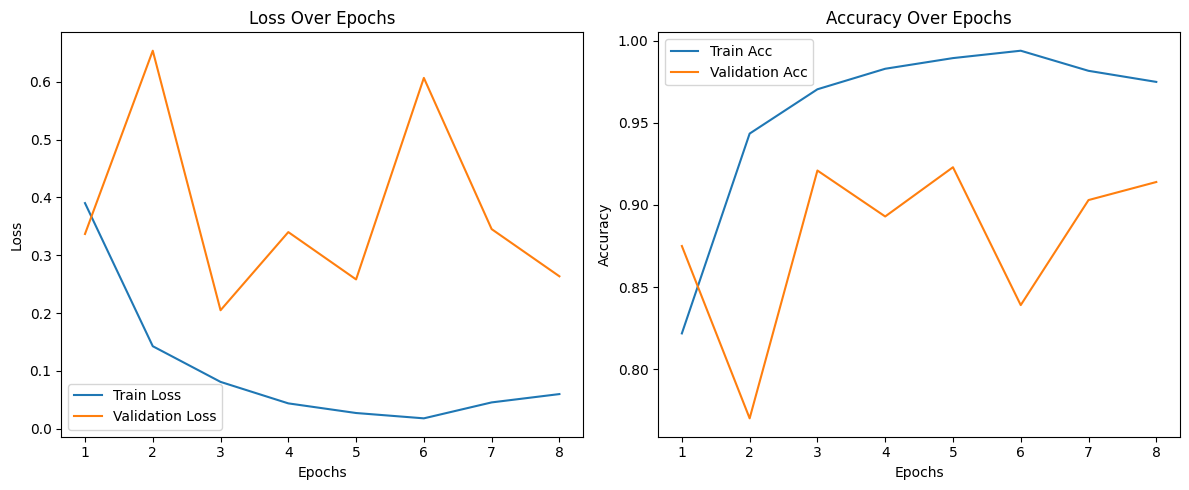

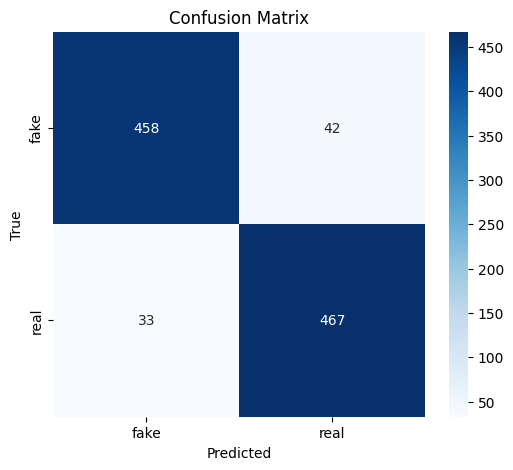

Accuracy: 0.9250
Recall (Sensitivity): 0.9340
F1-score: 0.9257
Specificity: 0.9160


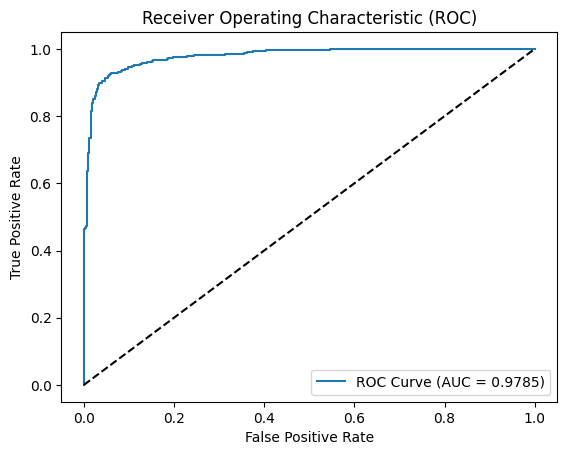

Total Parameters: 23510081
Trainable Parameters: 22065153
Average inference time per image (on 128 images): 0.000204 seconds


In [ ]:
# # 모델 정의
# model = get_resnet50_partial_tune().to(device)

# # 저장된 파라미터 로드
# model.load_state_dict(torch.load("checkpoints/resnet50_partial_4_best.pth", map_location=device))
test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")
# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 전체 fine-tuning

In [14]:
def get_resnet50_full_finetune():
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)  # binary classification

    # 전체 레이어 학습 가능 (기본값이지만 명시적 표현)
    for param in model.parameters():
        param.requires_grad = True

    return model

In [90]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_resnet50_full_finetune().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/resnet50_full_best_eyes_nose2.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        test_acc, test_loss = test(model, test_loader, device, criterion)
        print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/opt/anaconda3/envs/UR/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/UR/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.5036, train_acc = 0.7474 | val_loss = 0.4282, val_acc = 0.8020


  1%|          | 1/100 [00:38<1:03:30, 38.49s/it]

[Epoch 1] train_loss = 0.1418, train_acc = 0.9487 | val_loss = 0.4039, val_acc = 0.8530


  2%|▏         | 2/100 [01:29<1:15:03, 45.95s/it]

[Epoch 2] train_loss = 0.0733, train_acc = 0.9710 | val_loss = 0.5614, val_acc = 0.8220


  3%|▎         | 3/100 [02:26<1:22:28, 51.02s/it]

[Epoch 3] train_loss = 0.0577, train_acc = 0.9797 | val_loss = 0.3954, val_acc = 0.8620


  4%|▍         | 4/100 [03:24<1:26:08, 53.84s/it]

[Epoch 4] train_loss = 0.0372, train_acc = 0.9865 | val_loss = 0.5879, val_acc = 0.8280


  5%|▌         | 5/100 [04:21<1:27:02, 54.98s/it]

[Epoch 5] train_loss = 0.0355, train_acc = 0.9880 | val_loss = 0.4695, val_acc = 0.8720


  6%|▌         | 6/100 [05:17<1:26:30, 55.21s/it]

[Epoch 6] train_loss = 0.0285, train_acc = 0.9900 | val_loss = 0.4440, val_acc = 0.8700


  7%|▋         | 7/100 [06:12<1:25:13, 54.98s/it]

[Epoch 7] train_loss = 0.0226, train_acc = 0.9925 | val_loss = 0.3727, val_acc = 0.8930


  8%|▊         | 8/100 [07:06<1:23:55, 54.73s/it]

[Epoch 8] train_loss = 0.0184, train_acc = 0.9925 | val_loss = 0.3402, val_acc = 0.8880


  9%|▉         | 9/100 [08:00<1:22:51, 54.63s/it]

[Epoch 9] train_loss = 0.0119, train_acc = 0.9952 | val_loss = 0.4114, val_acc = 0.8820


 10%|█         | 10/100 [08:57<1:23:07, 55.42s/it]

[Epoch 10] train_loss = 0.0171, train_acc = 0.9955 | val_loss = 0.4091, val_acc = 0.8710


 11%|█         | 11/100 [09:55<1:23:11, 56.09s/it]

[Epoch 11] train_loss = 0.0126, train_acc = 0.9955 | val_loss = 0.4543, val_acc = 0.8710


 12%|█▏        | 12/100 [10:51<1:22:11, 56.04s/it]

[Epoch 12] train_loss = 0.0242, train_acc = 0.9917 | val_loss = 0.4183, val_acc = 0.8830


 13%|█▎        | 13/100 [11:48<1:21:49, 56.43s/it]

[Epoch 13] train_loss = 0.0116, train_acc = 0.9962 | val_loss = 0.5109, val_acc = 0.8580
Early stopping triggered


 13%|█▎        | 13/100 [12:52<1:26:09, 59.42s/it]

Final Test Accuracy: 0.8440


Final Test Accuracy: 0.9500


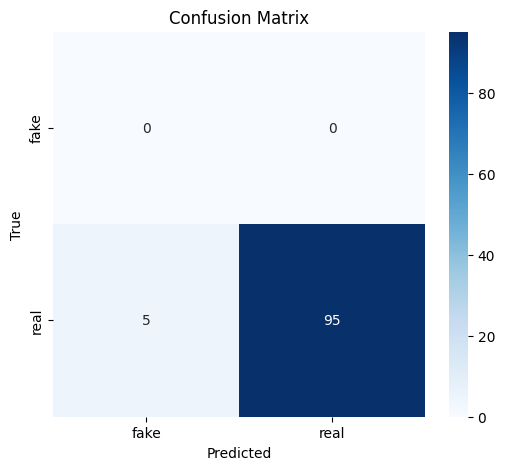

/opt/anaconda3/envs/UR/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/UR/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/UR/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/62/zx2trztj03q54g004dhxs

Accuracy: 0.9500
Recall (Sensitivity): 0.9500
F1-score: 0.9744
Specificity: nan


/opt/anaconda3/envs/UR/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


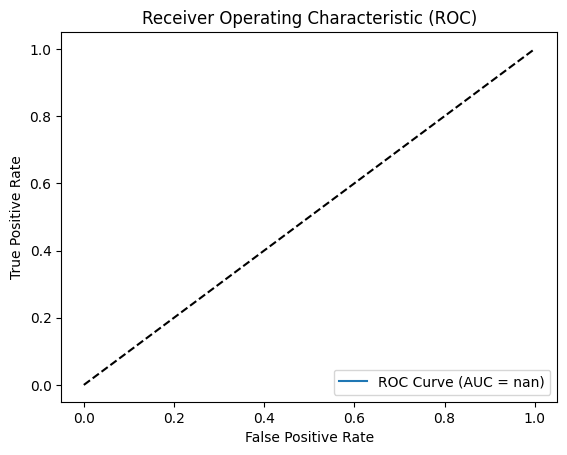

Total Parameters: 23510081
Trainable Parameters: 23510081
Average inference time per image (on 100 images): 0.007150 seconds


In [30]:
# 모델 정의
device="mps"
model = get_resnet50_full_finetune().to(device)
criterion = nn.BCEWithLogitsLoss()


# 저장된 파라미터 로드
model.load_state_dict(torch.load("/Users/kim-yujin/Desktop/Ajou univ_교과/2025/2025-1/기계학습/팀프로젝트/ResNet/resnet50_full_best_reg.pth", map_location=device))
test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")
# Accuracy, Loss 그래프
# plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### Grad-CAM 및 최종 성능 평가

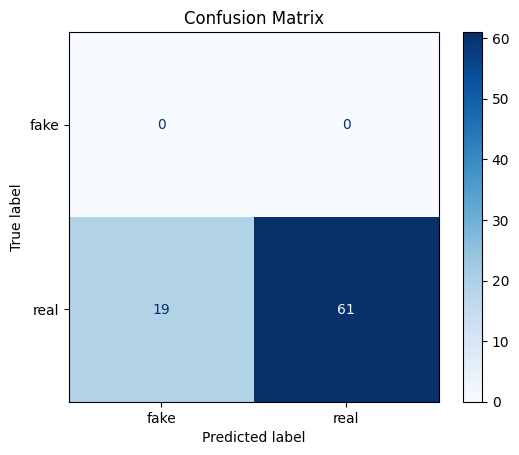


Classification Report:
              precision    recall  f1-score   support

        fake       0.00      0.00      0.00         0
        real       1.00      0.76      0.87        80

    accuracy                           0.76        80
   macro avg       0.50      0.38      0.43        80
weighted avg       1.00      0.76      0.87        80

ROC Curve는 클래스가 두 개 이상일 때만 가능합니다.


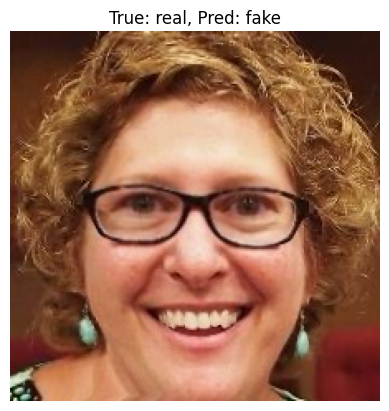

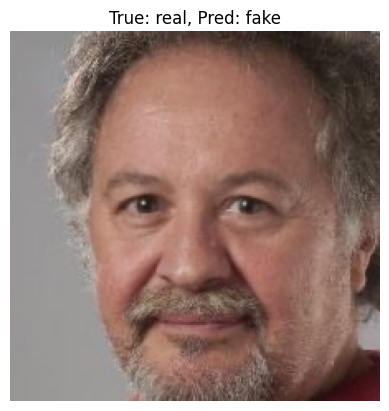

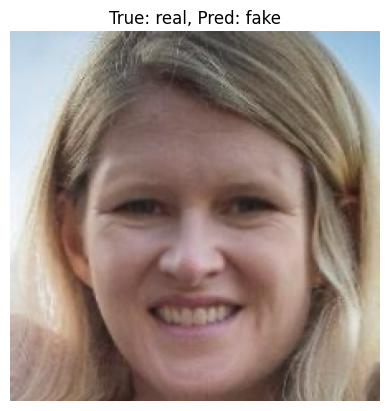

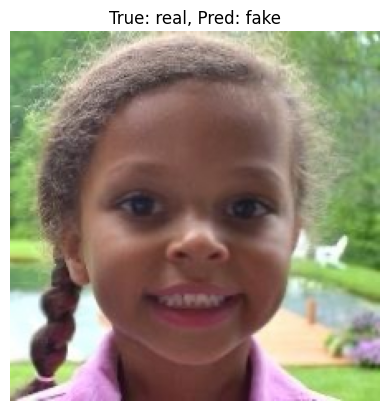

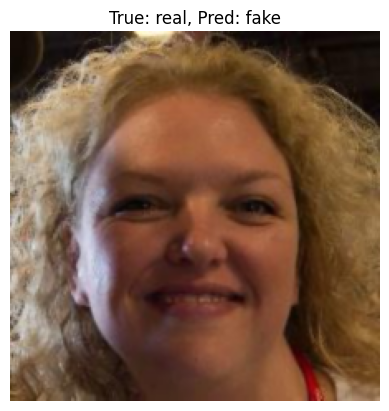

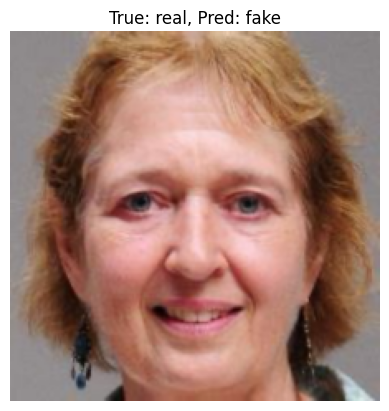

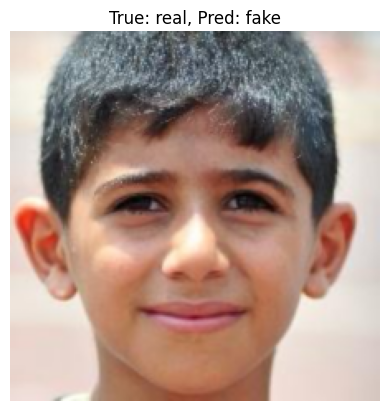

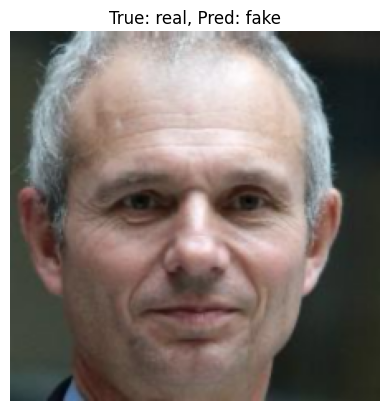

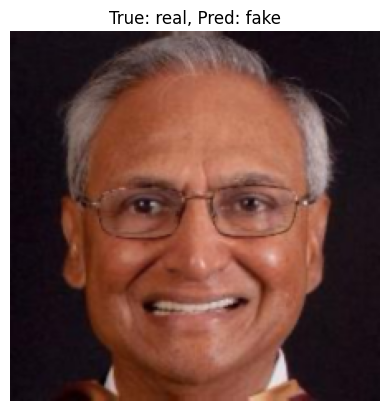

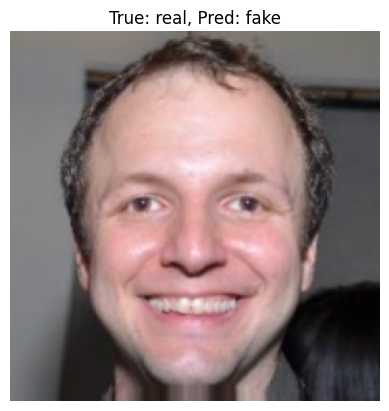

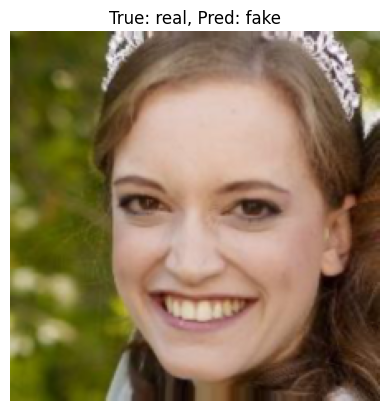

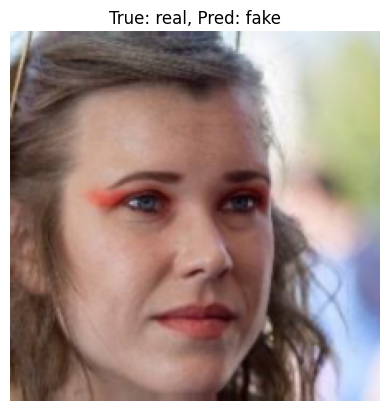

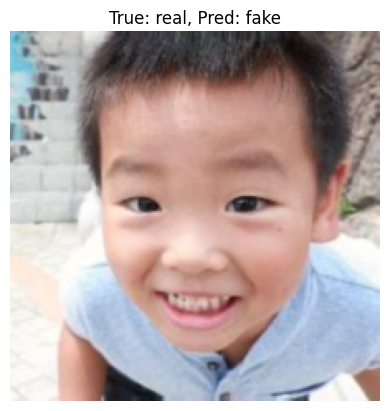

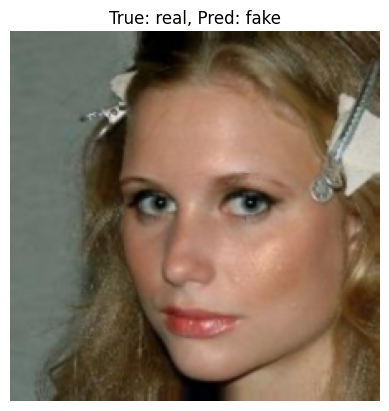

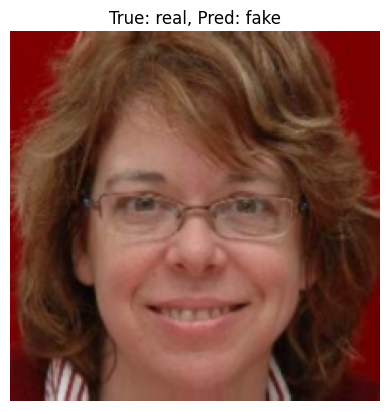

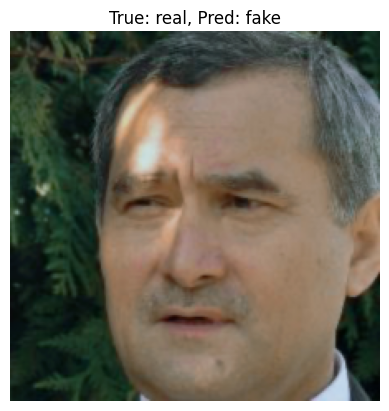

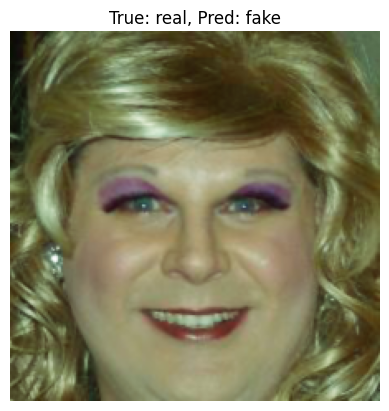

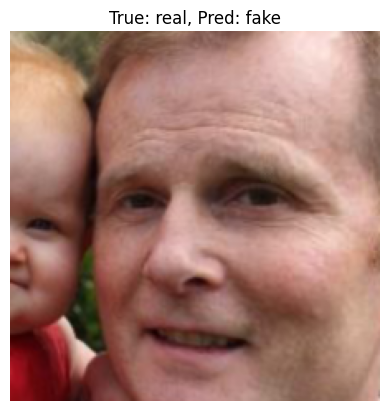

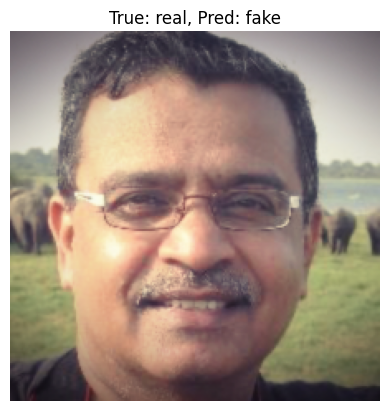

Total Parameters: 23,510,081 / Trainable: 23,510,081
Inference Time per Image: 0.013135 sec


In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from torch.utils.data import DataLoader

# 모델 정의 및 로드
model = get_resnet50_full_finetune().to(device)
model.load_state_dict(torch.load(
    "/Users/kim-yujin/Desktop/Ajou univ_교과/2025/2025-1/기계학습/팀프로젝트/ResNet/resnet50_full_best_reg.pth",
    map_location=device
))

# 공통 평가 함수 (예측 결과 수집)
def evaluate_and_collect(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            # ✅ sigmoid 기반 binary classifier
            probs = torch.sigmoid(outputs).squeeze()  # [batch_size]
            preds = (probs > 0.5).long()              # 0 또는 1

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)


# Confusion Matrix 출력
def plot_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# 정밀도, 재현율, 정확도 등
def print_classification_report(y_true, y_pred):
    print("\nClassification Report:")
    print(classification_report(
        y_true, y_pred,
        labels=[0, 1],
        target_names=['fake', 'real'],
        zero_division=0
    ))

# ROC 곡선
def plot_roc(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        print("ROC Curve는 클래스가 두 개 이상일 때만 가능합니다.")
        return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()

# 오분류 시각화
def show_misclassified_images(model, dataloader, preds, labels, class_names, max_images=19):
    model.eval()
    count = 0
    idx = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            batch_size = images.size(0)

            for i in range(batch_size):
                if idx >= len(preds):
                    return
                if preds[idx] != labels[idx]:
                    if count >= max_images:
                        return

                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    img = np.clip(img, 0, 1)

                    true_label = class_names[labels[idx]]
                    pred_label = class_names[preds[idx]]

                    plt.figure()
                    plt.imshow(img)
                    plt.title(f"True: {true_label}, Pred: {pred_label}")
                    plt.axis('off')
                    plt.show()

                    count += 1
                idx += 1

# 파라미터 개수
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total:,} / Trainable: {trainable:,}")

# 추론 시간 측정
import time
def measure_inference_time_per_image(model, dataloader, device):
    model.eval()
    n_images = 0
    start_time = time.time()
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            _ = model(images)
            n_images += images.size(0)
    elapsed = time.time() - start_time
    print(f"Inference Time per Image: {elapsed / n_images:.6f} sec")

# 클래스 이름
class_names = ['fake', 'real']

# 평가 실행
preds, labels, probs = evaluate_and_collect(model, test_loader, device)

# Confusion Matrix
plot_confusion(labels, preds, class_names)

# 지표
print_classification_report(labels, preds)

# ROC
plot_roc(labels, probs)

# 오분류 시각화
show_misclassified_images(model, test_loader, preds, labels, class_names)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)


/opt/anaconda3/envs/UR/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/UR/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


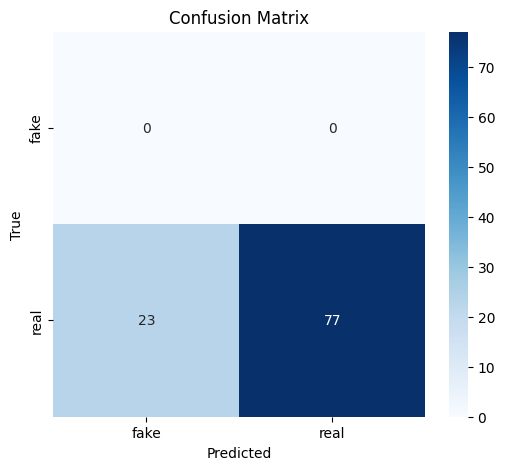

/opt/anaconda3/envs/UR/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/UR/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/UR/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/62/zx2trztj03q54g004dhxs

Accuracy: 0.7700
Recall (Sensitivity): 0.7700
F1-score: 0.8701
Specificity: nan


/opt/anaconda3/envs/UR/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


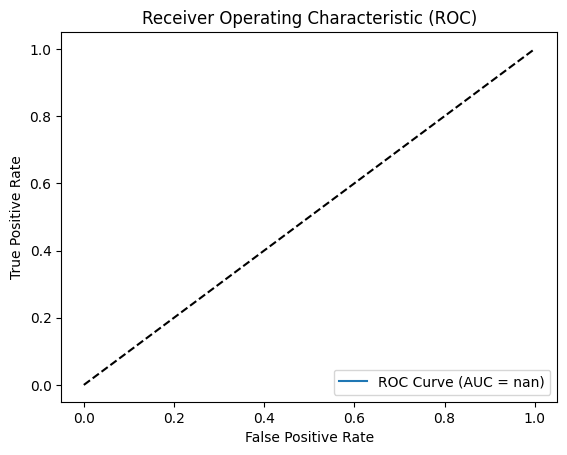

Total Parameters: 23510081
Trainable Parameters: 23510081
Average inference time per image (on 100 images): 0.000656 seconds


In [54]:
# 모델 정의
model = get_resnet50_full_finetune().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("/Users/kim-yujin/Desktop/Ajou univ_교과/2025/2025-1/기계학습/팀프로젝트/ResNet/resnet50_full_best_reg.pth", map_location=device))

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

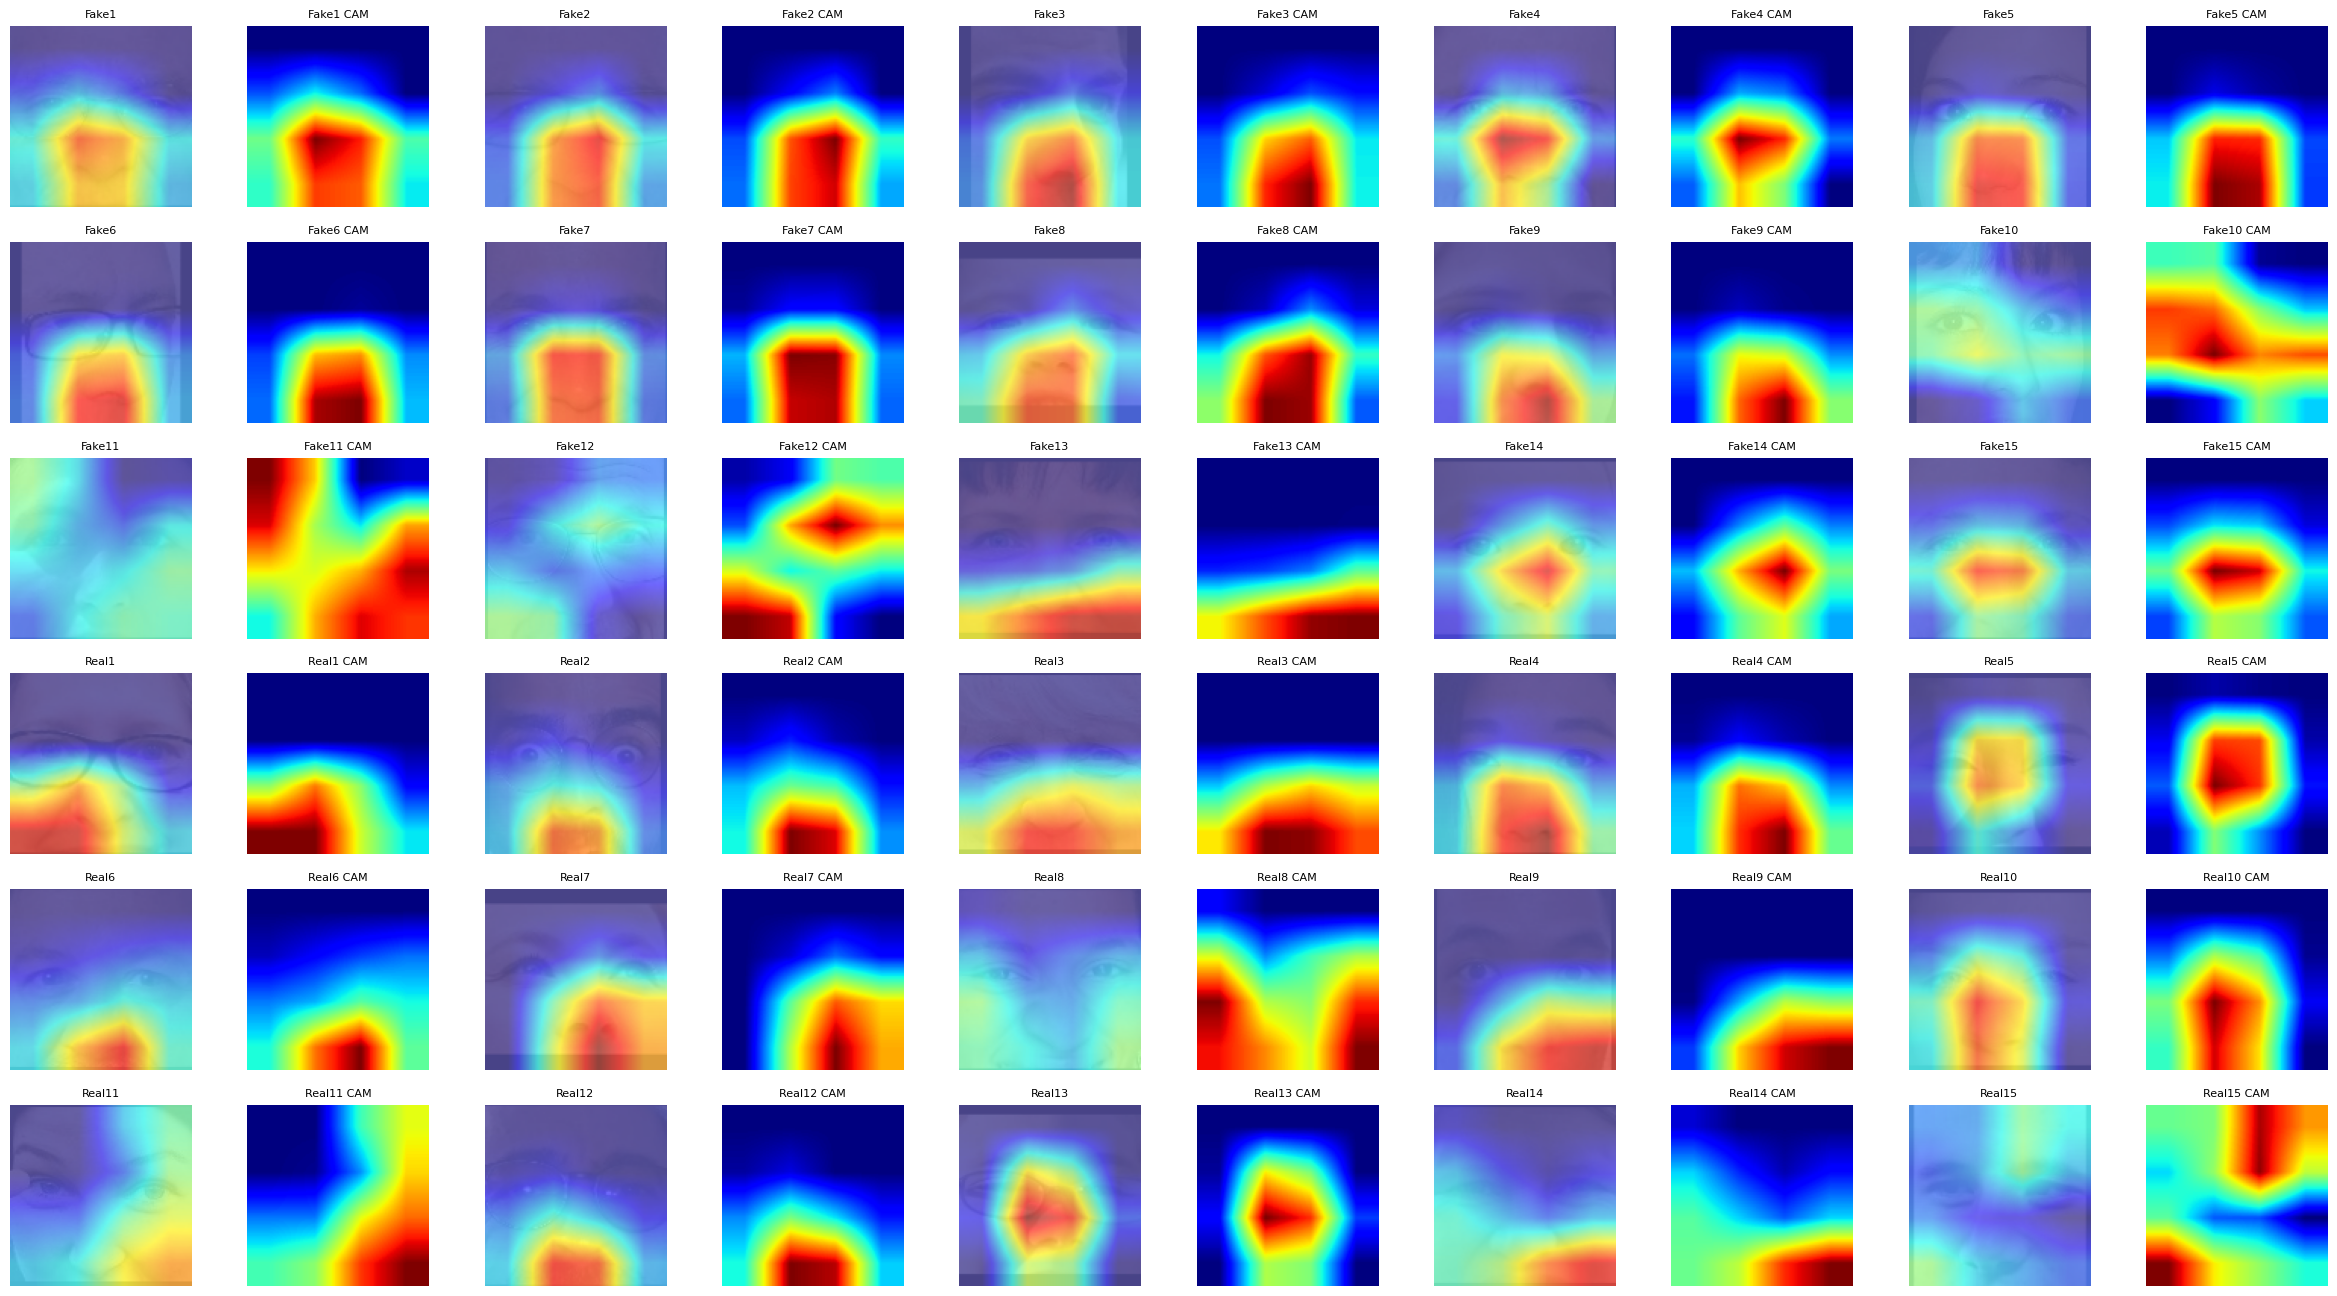

In [23]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# 모델 정의
model = get_resnet50_full_finetune().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("/Users/kim-yujin/Desktop/Ajou univ_교과/2025/2025-1/기계학습/팀프로젝트/checkpoints/resnet50_full_best_eyes_nose.pth", map_location=device))

# 마지막 Convolution layer 설정 (MobileNet 기준)
target_layer = model.layer4[-1]

# Grad-CAM 객체 생성
cam = GradCAM(model=model, target_layers=[target_layer])

# Normalize 해제 (ImageNet 기준일 경우)
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def show_gradcam_examples():
    fake_imgs = []
    real_imgs = []

    # 15장씩 수집
    for images, labels in test_loader:
        for img, label in zip(images, labels):
            if label.item() == 0 and len(fake_imgs) < 15:
                fake_imgs.append(img)
            elif label.item() == 1 and len(real_imgs) < 15:
                real_imgs.append(img)
            if len(fake_imgs) == 15 and len(real_imgs) == 15:
                break
        if len(fake_imgs) == 15 and len(real_imgs) == 15:
            break

    all_imgs = fake_imgs + real_imgs
    all_labels = [0]*15 + [1]*15
    all_titles = [f"Fake{i+1}" for i in range(15)] + [f"Real{i+1}" for i in range(15)]

    plt.figure(figsize=(24, 14))  # 넓은 캔버스 확보

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        for idx, (img, label, title) in enumerate(zip(all_imgs, all_labels, all_titles)):
            input_tensor = img.unsqueeze(0).to(device)
            targets = [BinaryClassifierOutputTarget(label)]

            grayscale_cam = cam(
                input_tensor=input_tensor,
                targets=targets,
                eigen_smooth=True,
                aug_smooth=True
            )[0]

            img_np = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
            img_np = np.clip(img_np, 0, 1)  # 0~1로 클리핑
            cam_image = show_cam_on_image(img_np.astype(np.float32), grayscale_cam, use_rgb=True)


            # 행/열 위치 계산
            group_idx = idx % 15
            row_offset = 0 if label == 0 else 3  # Fake: 위, Real: 아래
            col = (group_idx % 5) * 2
            row = row_offset + (group_idx // 5)

            # Overlay
            plt.subplot(6, 10, row * 10 + col + 1)
            plt.imshow(cam_image)
            plt.title(title, fontsize=8)
            plt.axis('off')

            # CAM heatmap
            plt.subplot(6, 10, row * 10 + col + 2)
            plt.imshow(grayscale_cam, cmap='jet')
            plt.title(f"{title} CAM", fontsize=8)
            plt.axis('off')

    plt.tight_layout(h_pad=1.5, w_pad=0.5)
    plt.subplots_adjust(top=0.95, bottom=0.05)
    plt.show()

# 실행
show_gradcam_examples()


In [21]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /private/var/folders/62/zx2trztj03q54g004dhxsf6m0000gn/T/pip-req-build-xqvd8qex
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /private/var/folders/62/zx2trztj03q54g004dhxsf6m0000gn/T/pip-req-build-xqvd8qex
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl (37.3 MB)
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=ec254aefa1a66bbb56056a440afec2ce744f2c18e7a760a18b6dd16035ad5c9e
  Stored in directory: /private/var/folders/62/zx2trztj03q54g004dhxsf6m0000gn/T/pip-ephem-wheel-cache-xl624

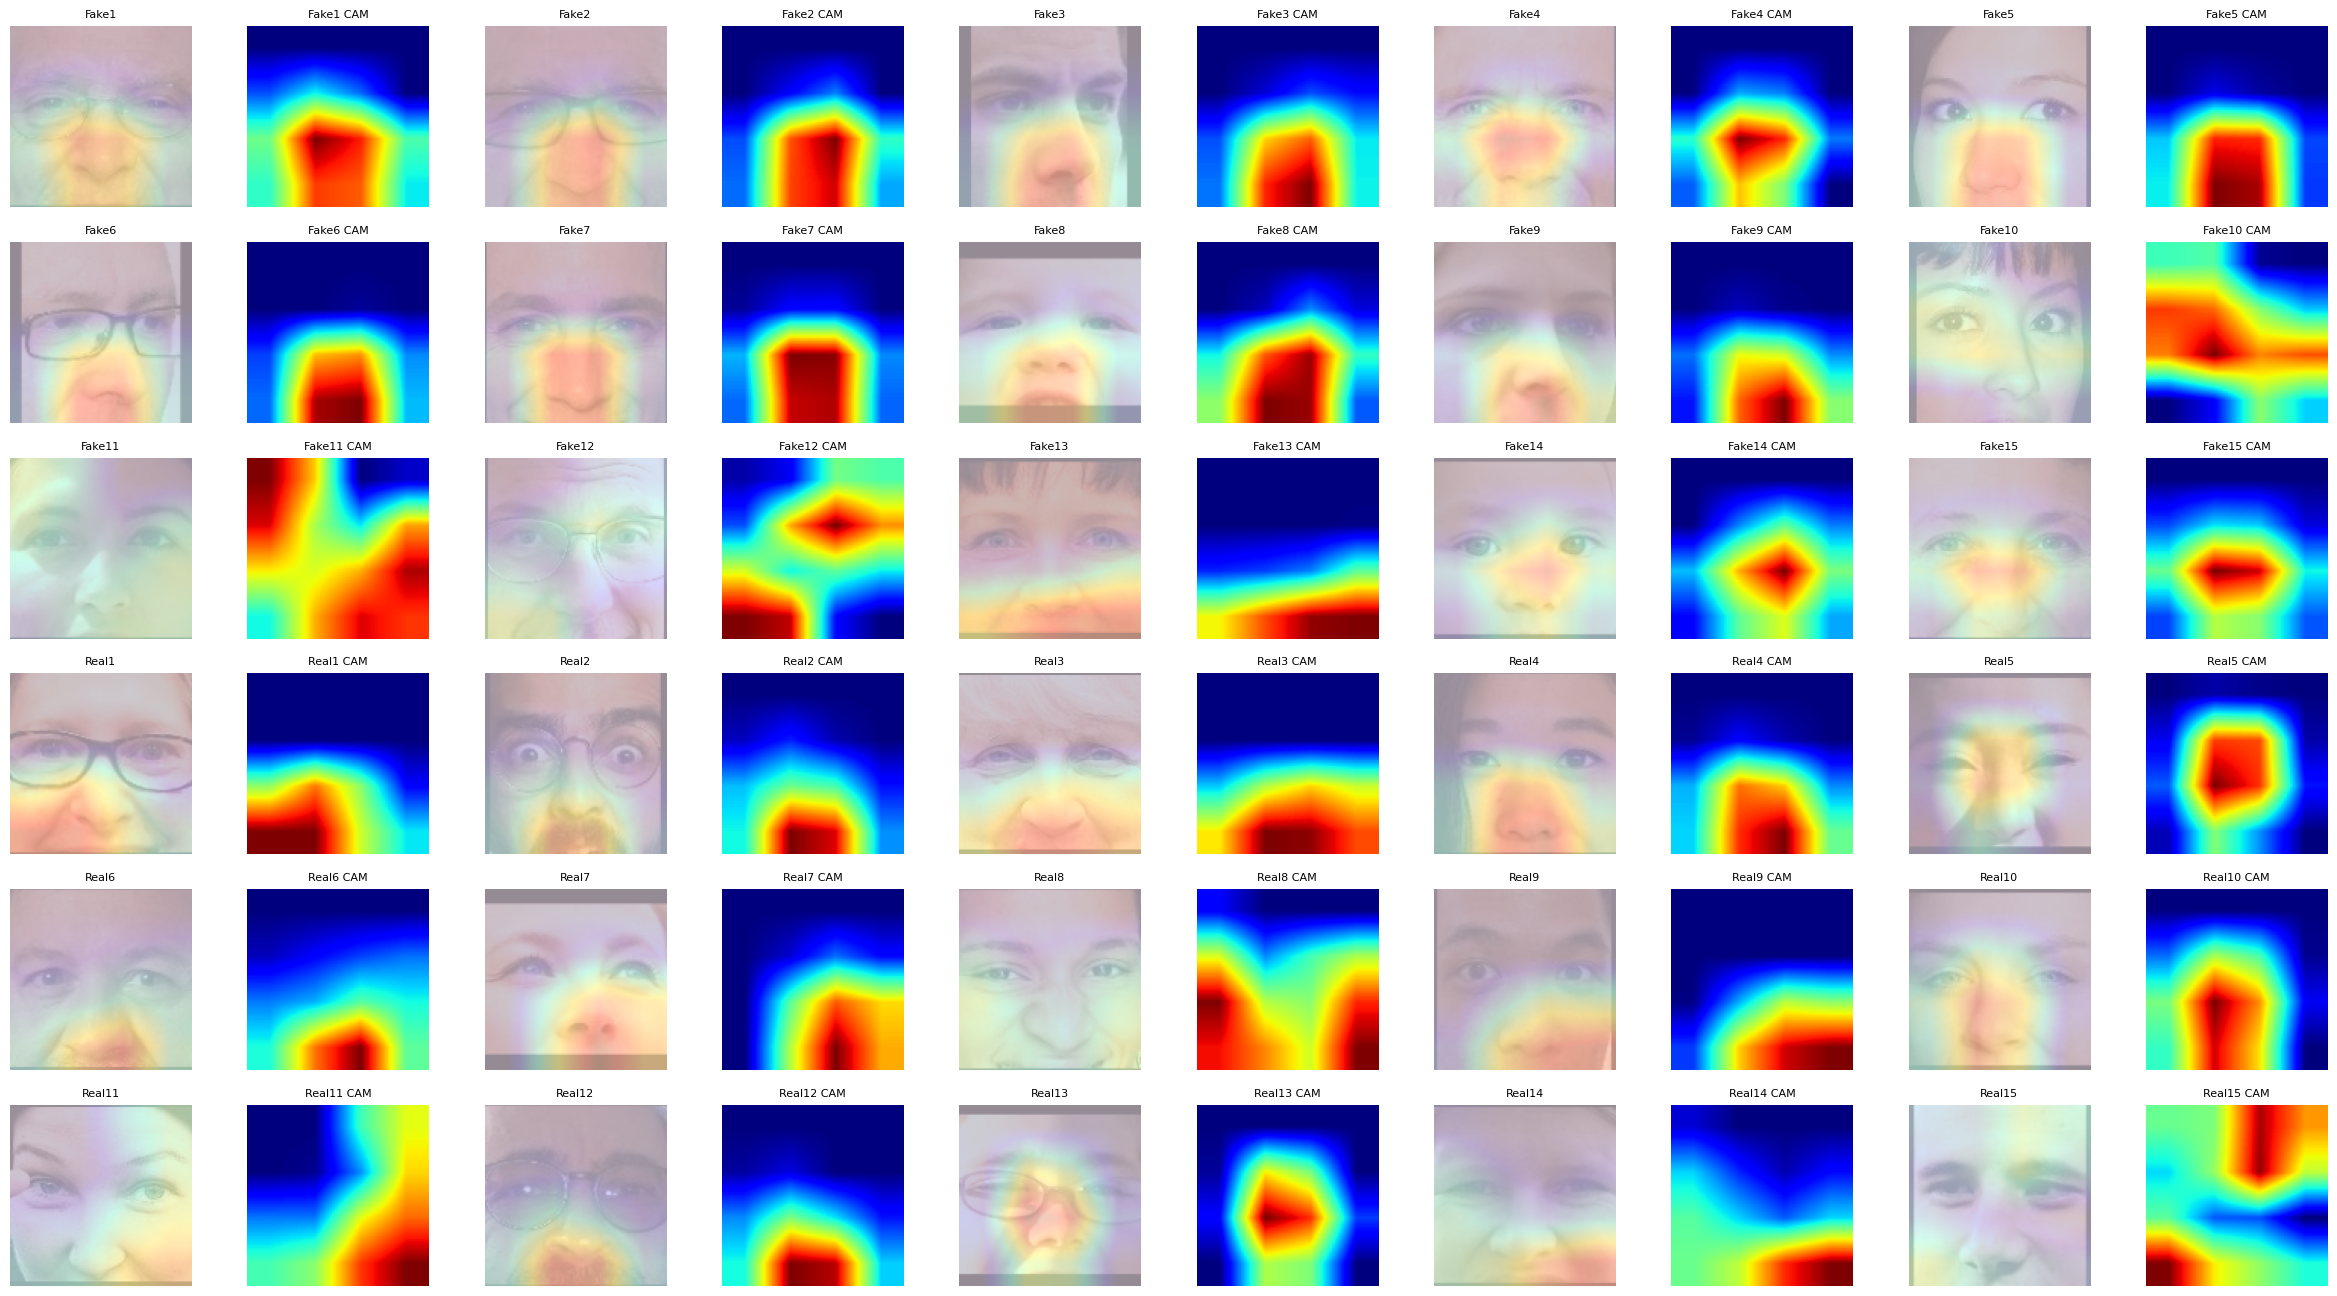

In [65]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch


# 모델 정의 및 로딩
model = get_resnet50_full_finetune().to(device)
model.load_state_dict(torch.load(
    "/Users/kim-yujin/Desktop/Ajou univ_교과/2025/2025-1/기계학습/팀프로젝트/checkpoints/resnet50_full_best_eyes_nose.pth",
    map_location=device
))

# 마지막 Conv layer (ResNet50 기준)
target_layer = model.layer4[-1]

# Grad-CAM 객체 생성
cam = GradCAM(model=model, target_layers=[target_layer])

# ImageNet 기준 역정규화
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def show_gradcam_examples():
    fake_imgs = []
    real_imgs = []

    # 15장씩 수집
    for images, labels in test_loader:
        for img, label in zip(images, labels):
            if label.item() == 0 and len(fake_imgs) < 15:
                fake_imgs.append(img)
            elif label.item() == 1 and len(real_imgs) < 15:
                real_imgs.append(img)
            if len(fake_imgs) == 15 and len(real_imgs) == 15:
                break
        if len(fake_imgs) == 15 and len(real_imgs) == 15:
            break

    all_imgs = fake_imgs + real_imgs
    all_labels = [0] * 15 + [1] * 15
    all_titles = [f"Fake{i+1}" for i in range(15)] + [f"Real{i+1}" for i in range(15)]

    plt.figure(figsize=(24, 14))  # 캔버스 넓게 설정

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        for idx, (img, label, title) in enumerate(zip(all_imgs, all_labels, all_titles)):
            input_tensor = img.unsqueeze(0).to(device)
            targets = [BinaryClassifierOutputTarget(label)]

            grayscale_cam = cam(
                input_tensor=input_tensor,
                targets=targets,
                eigen_smooth=True,
                aug_smooth=True
            )[0]

            # 역정규화 후 밝기 보정
            img_np = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
            img_np = np.clip(img_np * 1.5, 0, 1)  # 밝기 보정 후 클리핑

            # CAM과 원본 이미지 Overlay
            cam_image = show_cam_on_image(
                img_np.astype(np.float32),
                grayscale_cam,
                use_rgb=True,
                image_weight=0.8  # CAM 덮는 비율 (0.0 ~ 1.0)
            )

            # 행/열 위치 계산
            group_idx = idx % 15
            row_offset = 0 if label == 0 else 3  # Fake: 위쪽 3줄, Real: 아래쪽 3줄
            col = (group_idx % 5) * 2
            row = row_offset + (group_idx // 5)

            # Overlay 이미지
            plt.subplot(6, 10, row * 10 + col + 1)
            plt.imshow(cam_image)
            plt.title(title, fontsize=8)
            plt.axis('off')

            # CAM 히트맵
            plt.subplot(6, 10, row * 10 + col + 2)
            plt.imshow(grayscale_cam, cmap='jet')
            plt.title(f"{title} CAM", fontsize=8)
            plt.axis('off')

    plt.tight_layout(h_pad=1.5, w_pad=0.5)
    plt.subplots_adjust(top=0.95, bottom=0.05)
    plt.show()

# 실행
show_gradcam_examples()
